In [ ]:
 ##Exploratory Data Analysis (EDA) for ipl
#Use Python (pandas, seaborn, matplotlib, plotly) to perform IPL insights and visual storytelling:

#Combine and clean the relevant datasets
 
#Analyze run trends over the years
 
#Compare batting styles (anchor vs aggressive) via strike rate and boundary %
 
#Study bowling consistency (dot balls, economy rate, average)
 
#Visualize performance in different overs (Powerplay, Death)
 
#Compare venue behavior in high-scoring vs low-scoring matches

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [140]:
import pandas as pd

# Load ball-by-ball dataset
ball_by_ball = pd.read_csv(
    r"D:\capstone ipl\IPL_BallByBall2008_2024_Updated.csv",
    encoding='unicode_escape',
    on_bad_lines='skip',
    low_memory=False
)

# Load players info
players_info = pd.read_csv(
    r"D:\capstone ipl\Players_Info_2024.csv",
    encoding='unicode_escape',
    on_bad_lines='skip'
)

# Load team performance data
team_perf = pd.read_csv(
    r"D:\capstone ipl\team_performance_dataset_2008to2024.csv",
    encoding='unicode_escape',
    on_bad_lines='skip'
)



In [141]:
# Clean column names
def clean_columns(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '').str.replace('-', '')
    return df

ball_by_ball = clean_columns(ball_by_ball)
players_info = clean_columns(players_info)
team_perf = clean_columns(team_perf)


# Show column names
print("ball_by_ball columns:", ball_by_ball.columns.tolist())
print("players_info columns:", players_info.columns.tolist())
print("team_perf columns:", team_perf.columns.tolist())


# Null summary
print("Ball by Ball nulls:\n", ball_by_ball.isnull().sum())
print("Players Info nulls:\n", players_info.isnull().sum())
print("Team Perf nulls:\n", team_perf.isnull().sum())


ball_by_ball columns: ['matchid', 'date', 'season', 'battingteam', 'bowlingteam', 'inningsno', 'ballno', 'bowler', 'striker', 'nonstriker', 'runs_scored', 'extras', 'typeofextras', 'score', 'score/wicket', 'wicket_confirmation', 'wicket_type', 'fielders_involved', 'playerout']
players_info columns: ['playername', 'teamname', 'playernationality', 'dateofbirth', 'playerrole', 'ipldebut', 'about', 'battingstyle', 'bowlingstyle', 'playersalary']
team_perf columns: ['match_id', 'date', 'teams', 'venue', 'toss_winner', 'toss_decision', 'match_winner', 'win_type', 'win_margin', 'first_innings_score', 'second_innings_score', 'player_of_match', 'umpire', 'umpire1', 'umpire2', 'powerplay_scores', 'middle_overs_scores', 'death_overs_scores']
Ball by Ball nulls:
 matchid                     0
date                        0
season                      0
battingteam                 0
bowlingteam                 0
inningsno                   0
ballno                      0
bowler                      

In [142]:
# Merge player info with ball-by-ball using 'striker' → 'player_name'
ball_by_ball = ball_by_ball.merge(players_info, left_on='striker', right_on='playername', how='left')

# Drop 'player' column if it exists
if 'player' in ball_by_ball.columns:
    ball_by_ball = ball_by_ball.drop(columns=['player'])
    
# Summary
print("Merged shape:", ball_by_ball.shape)
print("Nulls after merge:\n", ball_by_ball.isnull().sum())

# If 'season' not present, extract from match_date
if 'season' not in ball_by_ball.columns and 'match_date' in ball_by_ball.columns:
    ball_by_ball['match_date'] = pd.to_datetime(ball_by_ball['match_date'], errors='coerce')
    ball_by_ball['season'] = ball_by_ball['match_date'].dt.year

# Ensure 'season' is cleaned (even if already present)
def extract_year(value):
    try:
        if isinstance(value, str) and '/' in value:
            return int(value.split('/')[0])
        return int(value)
    except:
        return None

ball_by_ball['season'] = ball_by_ball['season'].apply(extract_year)





Merged shape: (255759, 29)
Nulls after merge:
 matchid                     0
date                        0
season                      0
battingteam                 0
bowlingteam                 0
inningsno                   0
ballno                      0
bowler                      0
striker                     0
nonstriker                  0
runs_scored                 0
extras                      0
typeofextras           241936
score                       0
score/wicket                0
wicket_confirmation         0
wicket_type            243108
fielders_involved      246637
playerout              243108
playername             237445
teamname               237445
playernationality      237445
dateofbirth            237445
playerrole             237445
ipldebut               237698
about                  237445
battingstyle           237445
bowlingstyle           237445
playersalary           237445
dtype: int64


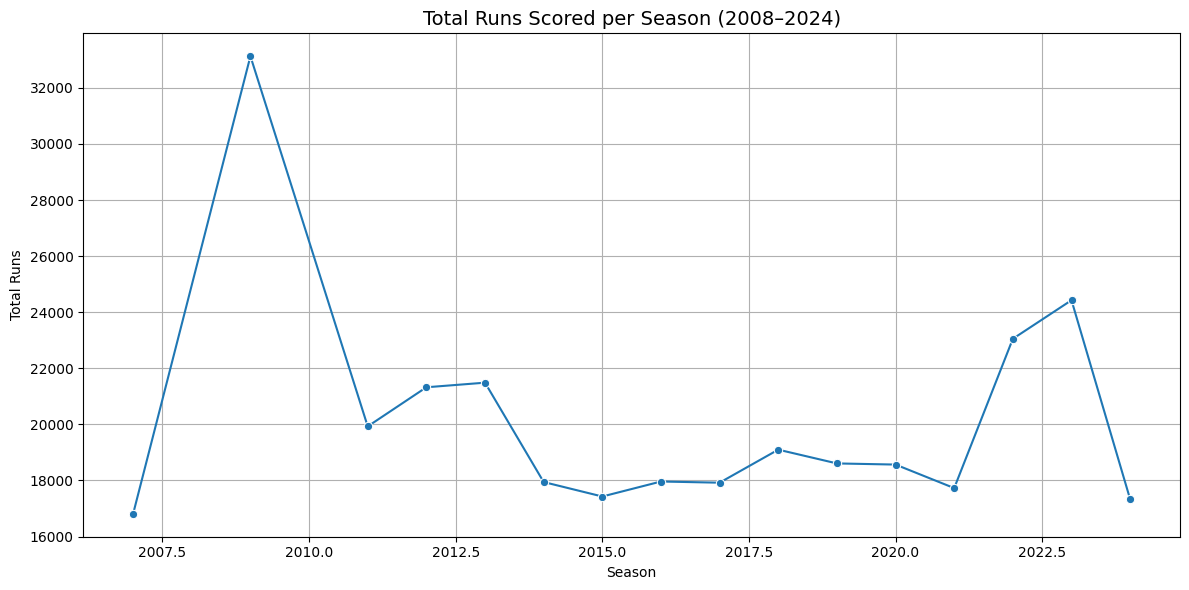

In [143]:
# Group and plot total runs per season
yearly_runs = ball_by_ball.groupby('season')['runs_scored'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_runs, x='season', y='runs_scored', marker='o')
plt.title('Total Runs Scored per Season (2008–2024)', fontsize=14)
plt.xlabel('Season')
plt.ylabel('Total Runs')
plt.grid(True)
plt.tight_layout()
plt.show()

In [144]:
#PART 3: Batting Style Comparison 
# Filter only legal deliveries
legal_deliveries['is_boundary'] = legal_deliveries['runs_scored'].isin([4, 6])



In [145]:
print(legal_deliveries.columns.tolist())



['matchid', 'date', 'season', 'battingteam', 'bowlingteam', 'inningsno', 'ballno', 'bowler', 'striker', 'nonstriker', 'runs_scored', 'extras', 'typeofextras', 'score', 'score/wicket', 'wicket_confirmation', 'wicket_type', 'fielders_involved', 'playerout', 'playername', 'teamname', 'playernationality', 'dateofbirth', 'playerrole', 'ipldebut', 'about', 'battingstyle', 'bowlingstyle', 'playersalary', 'over', 'over_phase', 'is_dot', 'is_wicket', 'is_boundary']


In [146]:
# Group by batsman
batting_summary = legal_deliveries.groupby('striker').agg(
    total_runs=('runs_scored', 'sum'),
    balls_faced=('striker', 'count'),
    boundaries=('is_boundary', 'sum')
).reset_index()


In [147]:
# Calculate strike rate and boundary %
batting_summary['strike_rate'] = (batting_summary['total_runs'] / batting_summary['balls_faced']) * 100
batting_summary['boundary_percent'] = (batting_summary['boundaries'] / batting_summary['balls_faced']) * 100


In [148]:
# Filter for minimum 100 balls faced
batting_summary = batting_summary[batting_summary['balls_faced'] >= 10]


In [149]:
# Merge player batting style
batting_summary = batting_summary.merge(
    players_info[['playername', 'battingstyle']],
    left_on='striker',
    right_on='playername',
    how='left'
)


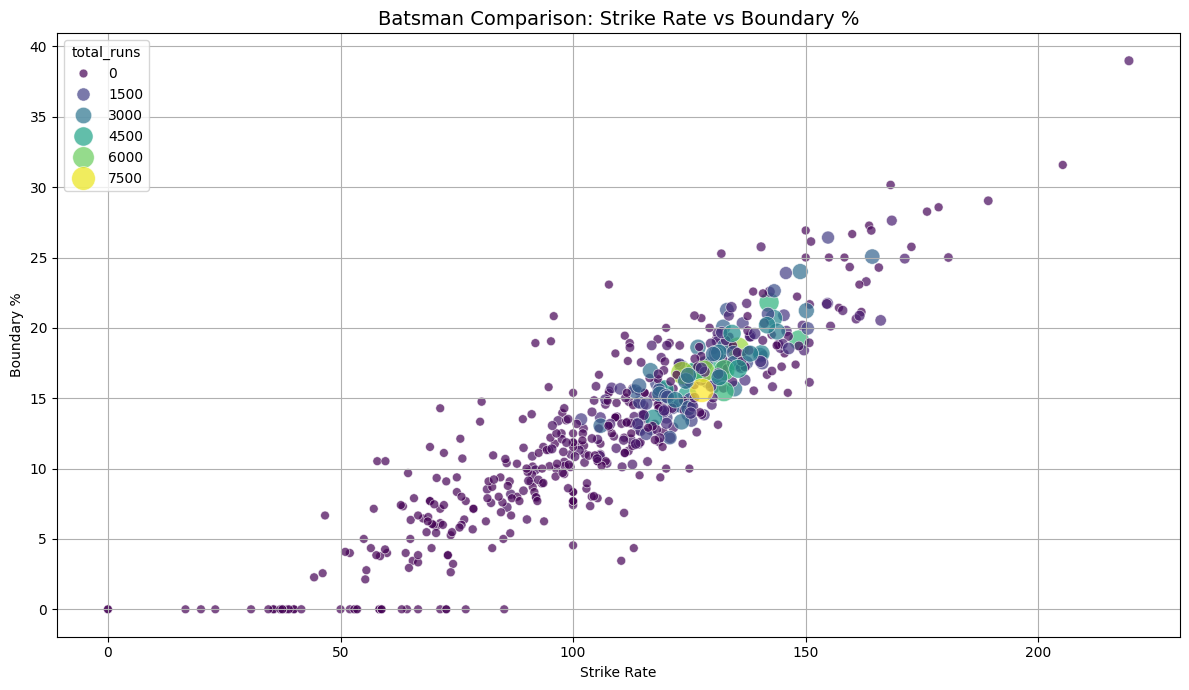

In [150]:
# Plot strike rate vs boundary %
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=batting_summary,
    x='strike_rate',
    y='boundary_percent',
    size='total_runs',         
    hue='total_runs',          
    sizes=(40, 300),
    palette='viridis',
    legend='brief',
    alpha=0.7
)
plt.title('Batsman Comparison: Strike Rate vs Boundary %', fontsize=14)
plt.xlabel('Strike Rate')
plt.ylabel('Boundary %')
plt.grid(True)
plt.tight_layout()
plt.show()







In [151]:
print(legal_deliveries.columns)


Index(['matchid', 'date', 'season', 'battingteam', 'bowlingteam', 'inningsno',
       'ballno', 'bowler', 'striker', 'nonstriker', 'runs_scored', 'extras',
       'typeofextras', 'score', 'score/wicket', 'wicket_confirmation',
       'wicket_type', 'fielders_involved', 'playerout', 'playername',
       'teamname', 'playernationality', 'dateofbirth', 'playerrole',
       'ipldebut', 'about', 'battingstyle', 'bowlingstyle', 'playersalary',
       'over', 'over_phase', 'is_dot', 'is_wicket', 'is_boundary'],
      dtype='object')


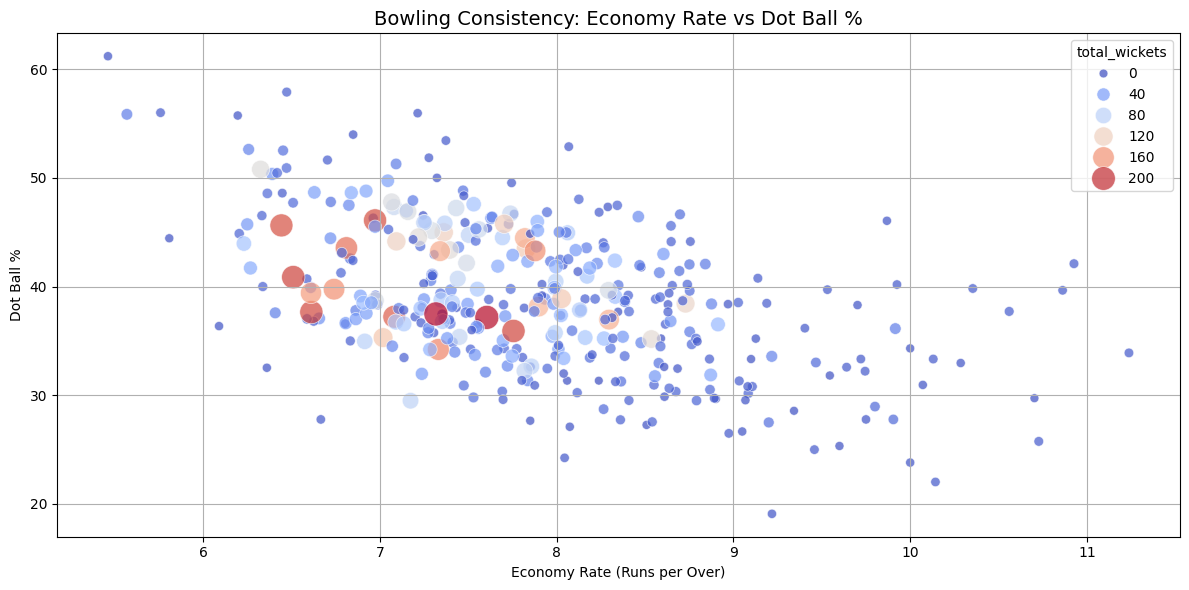

In [152]:
#PART 4: Bowling Consistency Metrics 

# 1. Work with all deliveries
legal_deliveries = ball_by_ball.copy()

# 2. Create is_dot and is_wicket columns
legal_deliveries['is_dot'] = legal_deliveries['runs_scored'] == 0
legal_deliveries['is_wicket'] = legal_deliveries['wicket_type'].notna()

# 3. Group by bowler
bowling_summary = legal_deliveries.groupby('bowler').agg(
    total_balls=('bowler', 'size'),           
    dot_balls=('is_dot', 'sum'),
    total_runs=('runs_scored', 'sum'),
    total_wickets=('is_wicket', 'sum')
).reset_index()

# 4. Calculate metrics
bowling_summary['overs_bowled'] = bowling_summary['total_balls'] / 6
bowling_summary['dot_ball_pct'] = (bowling_summary['dot_balls'] / bowling_summary['total_balls']) * 100
bowling_summary['economy_rate'] = bowling_summary['total_runs'] / bowling_summary['overs_bowled']
bowling_summary['bowling_average'] = bowling_summary['total_runs'] / bowling_summary['total_wickets']
bowling_summary.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# 5. Filter: At least 60 balls bowled
bowling_summary = bowling_summary[bowling_summary['total_balls'] >= 60]

# 6. Plot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=bowling_summary,
    x='economy_rate',
    y='dot_ball_pct',
    size='total_wickets',
    hue='total_wickets',
    palette='coolwarm',
    sizes=(40, 300),
    alpha=0.7,
    legend='brief'
)
plt.title("Bowling Consistency: Economy Rate vs Dot Ball %", fontsize=14)
plt.xlabel("Economy Rate (Runs per Over)")
plt.ylabel("Dot Ball %")
plt.grid(True)
plt.tight_layout()
plt.show()



In [153]:
print(ball_by_ball.columns.tolist())


['matchid', 'date', 'season', 'battingteam', 'bowlingteam', 'inningsno', 'ballno', 'bowler', 'striker', 'nonstriker', 'runs_scored', 'extras', 'typeofextras', 'score', 'score/wicket', 'wicket_confirmation', 'wicket_type', 'fielders_involved', 'playerout', 'playername', 'teamname', 'playernationality', 'dateofbirth', 'playerrole', 'ipldebut', 'about', 'battingstyle', 'bowlingstyle', 'playersalary']


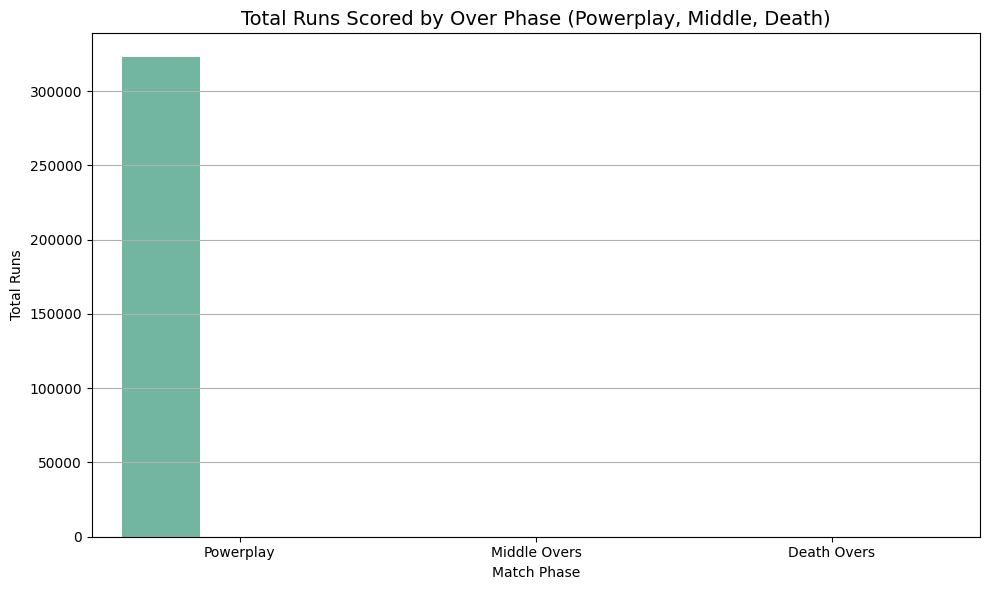

In [154]:
# PART 5: Performance by Over Phase (Powerplay, Middle, Death)
# Extract over number
ball_by_ball['over'] = (ball_by_ball['ballno'] // 6 + 1).astype(int)

# Classify overs into phases
# Classify match phase
def label_phase(over):
    if 1 <= over <= 6:
        return 'Powerplay'
    elif 7 <= over <= 15:
        return 'Middle Overs'
    elif 16 <= over <= 20:
        return 'Death Overs'
    else:
        return 'Other'

ball_by_ball['over_phase'] = ball_by_ball['over'].apply(label_phase)

# Group by phase
phase_summary = ball_by_ball.groupby('over_phase')['runs_scored'].sum().reset_index()

# Sort & plot
import seaborn as sns
import matplotlib.pyplot as plt

phase_order = ['Powerplay', 'Middle Overs', 'Death Overs']
phase_summary['over_phase'] = pd.Categorical(phase_summary['over_phase'], categories=phase_order, ordered=True)
phase_summary = phase_summary.sort_values('over_phase')

plt.figure(figsize=(10, 6))
sns.barplot(data=phase_summary, x='over_phase', y='runs_scored', hue='over_phase', palette='Set2', legend=False)
plt.title('Total Runs Scored by Over Phase (Powerplay, Middle, Death)', fontsize=14)
plt.xlabel('Match Phase')
plt.ylabel('Total Runs')
plt.grid(axis='y')
plt.tight_layout()
plt.show()






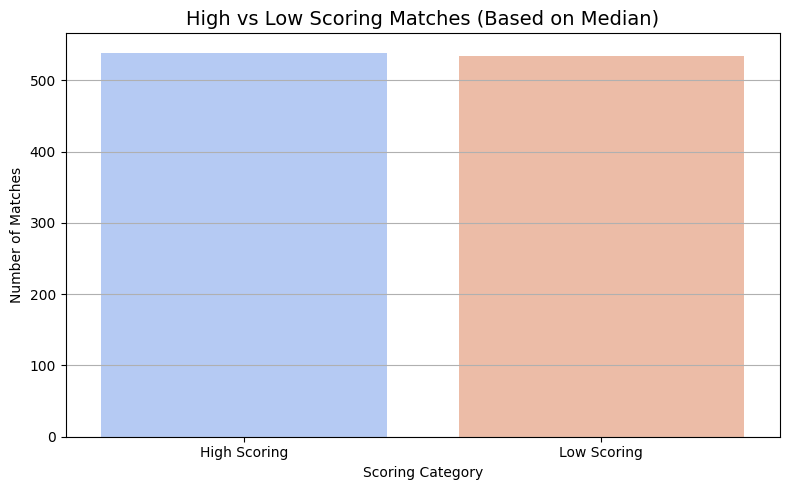

In [155]:
#  PART 6: Venue Behavior in High vs Low Scoring Matches

# Step 1: Total runs per match
match_runs = ball_by_ball.groupby('matchid')['runs_scored'].sum().reset_index()

# Step 2: Median split
median_runs = match_runs['runs_scored'].median()

# Step 3: Classify match type
match_runs['scoring_type'] = match_runs['runs_scored'].apply(
    lambda x: 'High Scoring' if x >= median_runs else 'Low Scoring'
)

# Step 4: Count match types
summary = match_runs['scoring_type'].value_counts().reset_index()
summary.columns = ['Scoring Type', 'Match Count']

# Step 5: Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(
    data=summary,
    x='Scoring Type',
    y='Match Count',
    hue='Scoring Type',
    palette='coolwarm',
    legend=False
)
plt.title('High vs Low Scoring Matches (Based on Median)', fontsize=14)
plt.xlabel('Scoring Category')
plt.ylabel('Number of Matches')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
